# Procedural

Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

In [3]:
!pip install psutil

In [4]:
import time
import pandas as pd
import torch
import numpy as np
from torch import nn, optim, utils
import psutil
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import random
import transformers
import re

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
RANDOM_SEED = 42

# Prepare the data for training

Set the hyperparameters needed for data preparation

In [6]:
BATCH_SIZE = 16

MODEL_NAME = "bert-base-cased"

MAX_LEN = 80
DATA_TO_CLASSIFY = "comments_body"

VALID_TEST_PROPORTION = 0.2 if "posts" in DATA_TO_CLASSIFY else 0.05

Fetch the test data and create a new series

In [7]:
if "posts" in DATA_TO_CLASSIFY:
    df = pd.read_csv('drive/MyDrive/MastersProject/data/aita_clean.csv')
    df['text'] = df["title"] + " " + df["body"].fillna("")

elif "comments" in DATA_TO_CLASSIFY:
    df = pd.read_csv('drive/MyDrive/MastersProject/data/comments_for_bert_no_etiquettes.csv')

    # Set comment ids as the indices for the dataframe
    df.set_index("id", inplace=True)

else:
    raise ValueError("Invalid DATA_TO_CLASSIFY variable!")


In [8]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(df.body.head())

id
cg08970    I've been on the receiving end of this before from a man, and I can tell you that it was really scary. (Context: I am a woman). You're going to need to exercise some empathy here and try and understand why what you did wasn't okay. She's not a bitch, she's just really frightened.\n\nYou scared her with your initial texts. You should have just stayed away from her instead of trying to explain yourself, because she's already afraid of you. You made it worse because people generally, and usually unfairly, fear people with mental illnesses. By acting out, you really hurt her image of you as being balanced. Now that you've told her, she's even more* afraid of you because you've proven yourself to be cruel and unpredictable.\n\nEdit: Let me add that I am in no way judging you. This is just the way life is. Learn from this experience and move on. This just wasn't a great context to be vulnerable with her in this way because the trust between you two was already damaged. \n      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


Split the dataframes

In [9]:
df_train, df_valid_test = train_test_split(df, test_size=VALID_TEST_PROPORTION, shuffle=True, random_state=RANDOM_SEED)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

Inspect the shapes of the split dataframes

In [10]:
print("df_train:", df_train.shape)
print("df_valid:", df_valid.shape)
print("df_test: ", df_test.shape)

df_train: (582293, 4)
df_valid: (15323, 4)
df_test:  (15324, 4)


Create a function that corrects imbalance in a dataframe

In [11]:
def create_rebalanced_undersampled_dataframe(df):
    '''
    Rebalance a dataframe by undersampling the majority class
    '''

    valid_counts = torch.bincount(torch.tensor(df.is_asshole.values))
    prob_drop = (valid_counts[0] - valid_counts[1]) / valid_counts[0]

    idcs_to_drop = []
    for index, row in df.iterrows():
        if row.is_asshole == 0:
            drop = random.choices(["drop", "dont_drop"], [prob_drop, 1-prob_drop])
            if drop[0] == "drop":
                idcs_to_drop.append(index)
    df_rebalanced = df.drop(index=idcs_to_drop)
    print("df_rebalanced: ", df_rebalanced.shape)
    print("Occurrences of each class: ", torch.bincount(torch.tensor(df_rebalanced.is_asshole.values)))

    return df_rebalanced

Create a rebalanced validation dataframe

In [12]:
df_valid_reb = create_rebalanced_undersampled_dataframe(df_valid)

df_rebalanced:  (10346, 4)
Occurrences of each class:  tensor([5202, 5144])


Specify the dataset class

In [13]:
class AITADatasetTrain(utils.data.Dataset):
    # Upon onject instance creation, you feed the text samples, their targets, the tokeniser and the max length.
    def __init__(self, texts, targets, tokeniser, max_len, weight_per_class):
        self.texts = texts
        self.targets = targets
        self.tokeniser = tokeniser
        self.max_len = max_len
        self.weight_per_class = weight_per_class
        
    def __len__(self):
        return len(self.texts)
    
    # This method is called when a batch is created. "item" is the index of each sample to be in batch.
    def __getitem__(self, item):
        # Normally it is already a string
        text = str(self.texts[item])

        # Create a dictionary constituting the encoding of the current item (i.e. current text)
        encoding = tokeniser(
            text,
            truncation=True,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt')
        
        # These are unnecessary I think
        encoding['input_ids'] = encoding['input_ids'].flatten()
        encoding['attention_mask'] = encoding['attention_mask'].flatten()

        # Find the weight that the current sample should have during training
        w = weight_per_class[self.targets[item]]
        
        # In the encoding dictionary for the current text, add the target corresponding to it and the actual test
        dic_out = {'input_ids': encoding['input_ids'],
                   'attention_mask': encoding['attention_mask'],
                   'targets': torch.tensor(self.targets[item], dtype=torch.long),
                   'sample_text': text,
                   'weights': w}
        
        return dic_out

In [14]:
class AITADatasetNoWeights(utils.data.Dataset):
    # Upon onject instance creation, you feed the text samples, their targets, the tokeniser and the max length.
    def __init__(self, texts, targets, tokeniser, max_len):
        self.texts = texts
        self.targets = targets
        self.tokeniser = tokeniser
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    # This method is called when a batch is created. "item" is the index of each sample to be in batch.
    def __getitem__(self, item):
        # Normally it is already a string
        text = str(self.texts[item])

        # Create a dictionary constituting the encoding of the current item (i.e. current text)
        encoding = tokeniser(
            text,
            truncation=True,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt')
        
        # These are unnecessary I think
        encoding['input_ids'] = encoding['input_ids'].flatten()
        encoding['attention_mask'] = encoding['attention_mask'].flatten()
        
        # In the encoding dictionary for the current text, add the target corresponding to it and the actual test
        dic_out = {'input_ids': encoding['input_ids'],
                   'attention_mask': encoding['attention_mask'],
                   'targets': torch.tensor(self.targets[item], dtype=torch.long),
                   'sample_text': text}
        
        return dic_out

Make a function that creates a dataloader for BERT

In [15]:
def create_dataloader_with_weights(df, tokeniser, max_len, batch_size, weight_per_class, data_to_classify):
    '''
    Creates a dataset from the given dataframe and a dataloader spitting batches of the dataset
    '''
    if "text" in data_to_classify:
        ds = AITADatasetTrain(
            texts=df.text.to_numpy(),
            targets=df.is_asshole.to_numpy(),
            tokeniser=tokeniser,
            max_len=max_len,
            weight_per_class=weight_per_class)
    elif "body" in data_to_classify:
        ds = AITADatasetTrain(
            texts=df.body.to_numpy(),
            targets=df.is_asshole.to_numpy(),
            tokeniser=tokeniser,
            max_len=max_len,
            weight_per_class=weight_per_class)
    elif "title" in data_to_classify:
        ds = AITADatasetTrain(
            texts=df.title.to_numpy(),
            targets=df.is_asshole.to_numpy(),
            tokeniser=tokeniser,
            max_len=max_len,
            weight_per_class=weight_per_class)
    else:
        raise ValueError("Data to classify not recognised!")
    
    dataloader = utils.data.DataLoader(ds, batch_size=batch_size, num_workers=2, drop_last=True)
    
    return dataloader

In [16]:
def create_dataloader_no_weights(df, tokeniser, max_len, batch_size, data_to_classify):
    '''
    Creates a dataset from the given dataframe and a dataloader spitting batches of the dataset
    '''
    if "text" in data_to_classify:
        ds = AITADatasetTrain(
            texts=df.text.to_numpy(),
            targets=df.is_asshole.to_numpy(),
            tokeniser=tokeniser,
            max_len=max_len,
            weight_per_class=weight_per_class)
    elif "body" in data_to_classify:
        ds = AITADatasetTrain(
            texts=df.body.to_numpy(),
            targets=df.is_asshole.to_numpy(),
            tokeniser=tokeniser,
            max_len=max_len,
            weight_per_class=weight_per_class)
    elif "title" in data_to_classify:
        ds = AITADatasetTrain(
            texts=df.title.to_numpy(),
            targets=df.is_asshole.to_numpy(),
            tokeniser=tokeniser,
            max_len=max_len,
            weight_per_class=weight_per_class)
    else:
        raise ValueError("Data to classify not recognised!")
    
    dataloader = utils.data.DataLoader(ds, batch_size=batch_size, num_workers=2, drop_last=True)
    
    return dataloader

Make a function that calculates class weights that correct imbalance


In [17]:
def create_rebalancing_weights_per_class(df):
    '''
    Rebalance by weighing samples of each class by their inverse class occurrence rate during training
    '''
    counts = torch.bincount(torch.tensor(df.is_asshole.values))
    weight_per_class = []
    num_classes = len(counts)
    for i in range(0, num_classes):
        w = (sum(counts)) / (num_classes * counts[i])
        weight_per_class.append(w)
        print("class {}: occurrences = {}, weight = {}, occurrences * weight = {}".format(i, counts[i], w, w * counts[i]))
    print()
    print("These are the weights per class:", weight_per_class)
    return weight_per_class

Create the tokeniser to be used in creating the dataloaders

In [18]:
tokeniser = transformers.BertTokenizer.from_pretrained(MODEL_NAME)

Calculate the eights of each class to correct imbalance

In [19]:
weight_per_class = create_rebalancing_weights_per_class(df_train)

class 0: occurrences = 388044, weight = 0.7502924799919128, occurrences * weight = 291146.5
class 1: occurrences = 194249, weight = 1.4988313913345337, occurrences * weight = 291146.5

These are the weights per class: [tensor(0.7503), tensor(1.4988)]


Create the dataloaders

In [20]:
train_loader = create_dataloader_with_weights(df_train, tokeniser, MAX_LEN, BATCH_SIZE, weight_per_class, DATA_TO_CLASSIFY)
valid_loader = create_dataloader_with_weights(df_valid, tokeniser, MAX_LEN, BATCH_SIZE, weight_per_class, DATA_TO_CLASSIFY)
valid_reb_loader = create_dataloader_no_weights(df_valid_reb, tokeniser, MAX_LEN, BATCH_SIZE, DATA_TO_CLASSIFY)
test_loader = create_dataloader_no_weights(df_test, tokeniser, MAX_LEN, BATCH_SIZE, DATA_TO_CLASSIFY)

Inspect the train_loader

In [21]:
train_batch = next(iter(train_loader))
loader_keys = train_batch.keys()
print("Each loader batch is a dictionary with keys:", loader_keys)
print()
print("input_ids batch shape        :", train_batch['input_ids'].shape)
print("attention_mask batch shape   :", train_batch['attention_mask'].shape)
print("targets batch shape          :", train_batch['targets'].shape)
print("weights batch shape          :", train_batch['weights'].shape)
print()
print("targets batch:", train_batch['targets'][10:18])
print("weights batch:", train_batch['weights'][10:18])


Each loader batch is a dictionary with keys: dict_keys(['input_ids', 'attention_mask', 'targets', 'sample_text', 'weights'])

input_ids batch shape        : torch.Size([16, 80])
attention_mask batch shape   : torch.Size([16, 80])
targets batch shape          : torch.Size([16])
weights batch shape          : torch.Size([16])

targets batch: tensor([0, 1, 0, 0, 0, 0])
weights batch: tensor([0.7503, 1.4988, 0.7503, 0.7503, 0.7503, 0.7503])


# Create the classifier

Set the hyperparameters needed for creating the classifier

In [22]:
# Hyperparameters relevant to all classifier types
DROPOUT_PROPORTION = 0
BERT_OUTPUT_USED = "pooled"       # in {full, pooled}
CLASSIFIER_TYPE = "FFNN"        # in {FFNN, CNN, LSTM}
NUM_UNFROZEN_BERT_LAYERS = 8

# Hyperparameters relevant only to the FFNN
NUMBER_NEURONS_LAYER_1 = 0
NUMBER_NEURONS_LAYER_2 = 0
NUMBER_NEURONS_LAYER_3 = 0
NUMBER_NEURONS_LAYER_4 = 0
BATCHNORM_ON = True

# Hyperparameters relevant only to the CNN
CNN_CHANNELS_OUT = 10

# Hyperparameters relevant only to the LSTM
LSTM_HIDDEN_DIM = 100

Use GPU if available

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.empty_cache()
print(device)

cuda:0


Specify the architecture of the classifier including frozen BERT

In [24]:
class SentimentClassifier(nn.Module):
    '''
    The sentiment classifier class that includes BERT
    '''
    def __init__(self, device, batch_size, bert_out_to_classify, classifier_type, dropout_proportion, bert_max_seq_len, model_name, num_unfrozen_bert_layers,
                 
                 n_neurons_1, n_neurons_2, n_neurons_3, n_neurons_4, batchnorm_on,

                 CNN_channels_out,

                 LSTM_hidden_dim):
        super(SentimentClassifier, self).__init__()

        # Instantiate the straight forward attributes relating to all 3 classifier types
        self.dropout_proportion = dropout_proportion
        self.bert_out_to_classify = bert_out_to_classify
        self.classifier_type = classifier_type
        self.batch_size = batch_size
        self.device = device
        self.embedding_dim = 768
        self.max_seq_len = bert_max_seq_len
        self.batchnorm_on = batchnorm_on
        self.num_unfrozen_bert_layers = num_unfrozen_bert_layers

        # Instantiate BERT
        self.bert_config = transformers.BertConfig(vocab_size=28996, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, max_position_embeddings=512)
        self.bert = transformers.BertModel.from_pretrained(model_name, config=self.bert_config)
        # Freeze BERT so that its weights are not further fine-tuned from their pretrained values
        if self.bert_out_to_classify == "full":
            # modules = [self.bert.embeddings, *self.bert.encoder.layer[:], self.bert.pooler]
            modules = [self.bert.embeddings, *self.bert.encoder.layer[:12 - self.num_unfrozen_bert_layers], self.bert.pooler]
        else:
            modules = [self.bert.embeddings, *self.bert.encoder.layer[:12 - self.num_unfrozen_bert_layers]]
        for module in modules:     
            for param in module.parameters():
                param.requires_grad = False

        # First tackle the case of linear layers on top of BERT
        if self.classifier_type == "FFNN":

            # Establish the number of neurons each layer has
            self.n_neurons_1 = n_neurons_1
            self.n_neurons_2 = n_neurons_2
            self.n_neurons_3 = n_neurons_3
            self.n_neurons_4 = n_neurons_4       

            # Determine the features of each sample input into classification layers depending on whether it is pooled output or full last hidden state of BERT.
            if "pooled" in self.bert_out_to_classify:
                self.feats_in = self.embedding_dim
            elif "full" in self.bert_out_to_classify:
                self.feats_in = self.embedding_dim * self.max_seq_len
            else:
                raise ValueError("BERT output to classify not recognised")

            # Determine the number of layers based on the given neurons for each layer prior to the last which by default has 1 neuron.
            if self.n_neurons_1 == 0:
                self.num_layers = 1
            elif self.n_neurons_2 == 0:
                self.num_layers = 2
            elif self.n_neurons_3 == 0:
                self.num_layers = 3
            elif self.n_neurons_4 == 0:
                self.num_layers = 4
            else:
                self.num_layers = 5


           # Structure the architecture of the network depending on the number of layers and their number of neurons for the case WITH BATCHNORM
            if self.batchnorm_on:
                if self.num_layers == 1:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, 1),
                        nn.Sigmoid())

                elif self.num_layers == 2:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_1),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_1, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 3:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_1),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_2),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_2, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 4:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_1),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_2),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_2, self.n_neurons_3),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_3),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_3, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 5:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_1),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_2),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_2, self.n_neurons_3),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_3),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_3, self.n_neurons_4),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_4),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_4, 1),
                        nn.Sigmoid())
                    

            # Structure the architecture of the network depending on the number of layers and their number of neurons for the case WITHOUT BATCHNORM
            elif not self.batchnorm_on:
                if self.num_layers == 1:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, 1),
                        nn.Sigmoid())

                elif self.num_layers == 2:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_1, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 3:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_2, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 4:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_2, self.n_neurons_3),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_3, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 5:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_2, self.n_neurons_3),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_3, self.n_neurons_4),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_4, 1),
                        nn.Sigmoid())
                    
        
        # Now tackle the case of a CNN on top of BERT
        elif self.classifier_type == "CNN":
            if "full" not in self.bert_out_to_classify:
                # The input to the CNN needs to be embedding so it will always be the full hidden state output of BERT
                raise ValueError("Cannot have a CNN classifier on top of BERT pooled output!")

            # How many filters of each size to apply to input
            self.c_out = CNN_channels_out
            
            # Set kernel sizes
            self.kernel_1_size = 1
            self.kernel_2_size = 2
            self.kernel_3_size = 3
            self.kernel_4_size = 4
            self.kernel_5_size = 5
            self.kernel_6_size = 6

            # Set convolution layers
            self.conv_1 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_1_size, stride=1, padding=0)
            self.conv_2 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_2_size, stride=1, padding=0)
            self.conv_3 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_3_size, stride=1, padding=0)
            self.conv_4 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_4_size, stride=1, padding=0)
            self.conv_5 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_5_size, stride=1, padding=0)
            self.conv_6 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_6_size, stride=1, padding=0)

            # Set the max pooling layers
            self.pool_1 = nn.MaxPool1d(self.max_seq_len)
            self.pool_2 = nn.MaxPool1d(self.max_seq_len - 1)
            self.pool_3 = nn.MaxPool1d(self.max_seq_len - 2)
            self.pool_4 = nn.MaxPool1d(self.max_seq_len - 3)
            self.pool_5 = nn.MaxPool1d(self.max_seq_len - 4)
            self.pool_6 = nn.MaxPool1d(self.max_seq_len - 5)
            
            if self.batchnorm_on:
                # Set the fully connected output layer
                self.fc = nn.Sequential(
                    nn.BatchNorm1d(6 * self.c_out),
                    nn.Dropout(p=self.dropout_proportion),
                    nn.Linear(6 * self.c_out, 1),
                    nn.Sigmoid())
            else:

                # Set the fully connected output layer
                self.fc = nn.Sequential(
                    # nn.Dropout(p=self.dropout_proportion),
                    nn.Linear(6 * self.c_out, 1),
                    nn.Sigmoid())

        
        # Finally tackle the case of an LSTM on top of BERT
        elif self.classifier_type == "LSTM":
            if "full" not in self.bert_out_to_classify:
                # Once again, the input to the LSTM needs to be embeddings so it will always be the full hidden state output of BERT
                raise ValueError("Cannot have an LSTM classifier on top of BERT pooled output!")
            
            # Set the number of features in the hidden state vectors output from the LSTM
            self.hidden_dim = LSTM_hidden_dim

            # Instantiate the bidirectional LSTM
            self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, bidirectional=True)
            
            if self.batchnorm_on:
                # Instantiate the fully connected output layer
                self.hidden2label = nn.Sequential(
                    nn.BatchNorm1d(self.hidden_dim * 2),
                    nn.Dropout(p=self.dropout_proportion),
                    nn.Linear(self.hidden_dim * 2, 1),
                    nn.Sigmoid())
            else:
                 # Instantiate the fully connected output layer
                self.hidden2label = nn.Sequential(
                    # nn.Dropout(p=self.dropout_proportion),
                    nn.Linear(self.hidden_dim * 2, 1),
                    nn.Sigmoid())

            # intialise the hidden state vector
            self.hidden = self.init_hidden()


    def init_hidden(self):
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

                
    def forward(self, input_ids, attention_mask):

        dic_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        if self.classifier_type == "CNN":
            X = dic_out['last_hidden_state'].permute(0, 2, 1)

            # Apply Convolution layer 1
            x1 = self.conv_1(X)
            x1 = torch.relu(x1)
            x1 = self.pool_1(x1)
            
            # Apply Convolution layer 2
            x2 = self.conv_2(X)
            x2 = torch.relu((x2))
            x2 = self.pool_2(x2)
        
            # Apply Convolution layer 3
            x3 = self.conv_3(X)
            x3 = torch.relu(x3)
            x3 = self.pool_3(x3)
            
            # Apply Convolution layer 4
            x4 = self.conv_4(X)
            x4 = torch.relu(x4)
            x4 = self.pool_4(x4)

            # Apply Convolution layer 5
            x5 = self.conv_5(X)
            x5 = torch.relu(x5)
            x5 = self.pool_5(x5)

            # Apply Convolution layer 6
            x6 = self.conv_6(X)
            x6 = torch.relu(x6)
            x6 = self.pool_6(x6)
            
            # Concatenate outputs of convolutions into unique matrix
            union = torch.cat((x1, x2, x3, x4, x5, x6), 2)
            union = union.reshape(union.size(0), -1)

            # The "flattened" vector is passed through a fully connected layer
            out = self.fc(union)
            out = out.flatten()


        elif self.classifier_type == "FFNN":
            if self.bert_out_to_classify == "full":
                X = dic_out['last_hidden_state']
            else:
                X = dic_out['pooler_output']
            current_batch_size = X.shape[0]
            X = X.view(current_batch_size, -1)

            out = self.classifier(X)
            out = out.view(-1)


        elif self.classifier_type == "LSTM":

            # Get the full last hidden state of BERT of shape (batch_size x sequence_length x embedding_dim) = (128 x 512 x 768)
            X = dic_out['last_hidden_state']
            # Change its shape to (sequence_length x batch_size x embedding_dim) = (512 x 128 x 768) because that is how the LSTM likes its input
            X = X.permute(1, 0, 2)

            # Send X and the previous hidden state tuple through the LSTM and get: out_shape = (512 x 2*100) = (sequence_length x num_directions * hidden_dim) plus a new hidden state tuple
            lstm_out, hidden_out = self.lstm(X, self.hidden)
            # Detach the two new hidden state vectors because otherwise they are always connected to previous ones and gradients go deeper with each batch
            self.hidden = (hidden_out[0].detach(), hidden_out[1].detach())

            # Send the output of the LSTM through the fully connected layer
            out = self.hidden2label(lstm_out[-1])
            out = out.view(-1)
            
        return out

In [25]:
model = SentimentClassifier(device, BATCH_SIZE, BERT_OUTPUT_USED, CLASSIFIER_TYPE, DROPOUT_PROPORTION, MAX_LEN, MODEL_NAME, NUM_UNFROZEN_BERT_LAYERS,
                            NUMBER_NEURONS_LAYER_1, NUMBER_NEURONS_LAYER_2, NUMBER_NEURONS_LAYER_3, NUMBER_NEURONS_LAYER_4, BATCHNORM_ON, 
                            CNN_CHANNELS_OUT, LSTM_HIDDEN_DIM)
model = model.to(device)

# Print info on the model
print(model)
print()
model_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The total number of trainable parameters in the classifier is: {}".format(model_trainable_params))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

Checking the ouputs for a batch of inputs are as expected

In [26]:
# OPTIONAL

demo_input_ids = train_batch['input_ids'].to(device)
demo_input_masks = train_batch['attention_mask'].to(device)
with torch.no_grad():
    demo_out = model(demo_input_ids, demo_input_masks)
    print(demo_out)
    print(demo_out.shape)

tensor([0.5267, 0.5240, 0.5330, 0.4958, 0.5161, 0.5338, 0.5310, 0.5283, 0.5072,
        0.5148, 0.5071, 0.5319, 0.5326, 0.5167, 0.5290, 0.5081],
       device='cuda:0')
torch.Size([16])


# Training

Set the hyperparameters needed for training

In [30]:
LR = 0.0000008
EPOCHS = 7
OPTIMISER = "AdamW"   # in {SGD, AdamW}
WEIGHT_DECAY = 0.1

Create a function that yields evaluation metrics from a give confusion matrix

In [31]:
def get_metrics_from_conf_matrix(confusion_matrix: np.ndarray, print_on=False):
    '''
    Takes in a confusion matrix and deduces evaluation metrics based on it.

    params: confusion_matrix: numpy array giving the confusion matrix of binary classification
            print_on: Boolean determining whether or not to print input confusion matrix and deduced matrices
    return: Various self-explanatory evaluation metrics
    '''

    # Get TP, FP, FN, TN (with different names).
    true_asshole = confusion_matrix[1][1]
    false_asshole = confusion_matrix[0][1]
    true_sweetheart = confusion_matrix[0][0]
    false_sweetheart = confusion_matrix[1][0]

    # Calculate
    accuracy = (true_asshole + true_sweetheart) / (true_sweetheart + true_asshole + false_asshole + false_sweetheart)
    asshole_detection_precision = true_asshole / (true_asshole + false_asshole)
    sweetheart_detection_precision = true_sweetheart / (true_sweetheart + false_sweetheart)
    asshole_detection_accuracy = true_asshole / (true_asshole + false_sweetheart)
    sweetheart_detection_accuracy = true_sweetheart / (true_sweetheart + false_asshole)
    f1_ass = 2 * ((asshole_detection_precision * asshole_detection_accuracy) / (asshole_detection_precision + asshole_detection_accuracy))
    f1_sweet = 2 * ((sweetheart_detection_precision * sweetheart_detection_accuracy) / (sweetheart_detection_precision + sweetheart_detection_accuracy))

    # If print is on, print the input confusion matrix and its evaluation metrics
    if print_on:
        print("Here is the confusion matrix:")
        print(confusion_matrix)
        print()
        print("Here are the metrics derived from the confusion matrix:")
        print("recall wrt assholes =", asshole_detection_accuracy)
        print("recall wrt sweethearts =", sweetheart_detection_accuracy)
        print("precision wrt assholes =", asshole_detection_precision)
        print("precision wrt sweethearts) =", sweetheart_detection_precision)
        print()
        print("accuracy =", accuracy)
        print("f1 wrt assholes =", f1_ass)
        print("f1 wrt sweethearts =", f1_sweet)

    # Return various self explanatory evaluation metrics
    return(asshole_detection_accuracy, sweetheart_detection_accuracy,
           asshole_detection_precision, sweetheart_detection_precision,
           accuracy, f1_ass, f1_sweet)

Create a function that performs one epoch of training

In [32]:
def train_epoch(model, dataloader, optimiser, device, scheduler=None, print_on=False):
    '''
    Function that performs one epoch (one pass through each sample in the given loader) of training of the given model.
    '''

    model = model.train()

    # Create some things for storing and calculating training metrics on a per epoch level
    losses = []
    correct_predictions = 0
    total_predictions = 0

    # Create some lists for storing and calculating training metrics on a per some batches level
    many_batches_losses = []
    many_batches_accs = []
    for i, batch in enumerate(dataloader):
  
      # Isolate the numpy arrays from the current batch that are needed for training
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      y = batch['targets'].float().to(device)
      w = batch['weights'].to(device)

      # Pass the batch through the classifier (output layers)
      y_out = model(input_ids=input_ids, attention_mask=attention_mask)
      del input_ids, attention_mask

      # Binarise output probs to predictions in {0, 1}
      y_preds = y_out.detach()
      y_preds = torch.where(y_preds > 0.5, 1, 0)
      correct_predictions += int(torch.sum(y_preds == y))
      total_predictions += len(y_preds)
      many_batches_accs.append(torch.sum(y_preds == y) / len(y_preds))

      # Get the mean loss for the batch
      loss_fn = nn.BCELoss(weight=w, reduction="mean").to(device)
      loss = loss_fn(y_out, y.float())
      losses.append(loss.item())
      many_batches_losses.append(loss.item())
      loss.backward()
      
      # Not sure why I am clipping the grad here. Apparently it helps prevent exploding gradients.
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      # Take an optimisation step
      optimiser.step()
      if scheduler:
        scheduler.step()
      optimiser.zero_grad()

      torch.cuda.empty_cache()
      del y, w

      if print_on:
      # Every so often print the current training accuracy
        if (i + 1) % 100 == 0:
          print("...Batch #{} : Training Loss={}, Training Accuracy={}".format(i + 1, sum(many_batches_losses) / len(many_batches_losses), sum(many_batches_accs) / len(many_batches_accs)))
          many_batches_losses = []
          many_batches_accs = []

    # Return the training accuracy and the mean training loss for the given epoch
    return correct_predictions / total_predictions, np.mean(losses)

Create a function that performs one epoch of evaluation

In [33]:
def eval_model(model, dataloader, device, include_weights=True, print_conf_matr_on=True):
    '''
    Function that performs evaluation of the given model for one full pass of the samples in the give dataloader
    '''

    model = model.eval()

    losses = []
    # Instantiate the total confusion metric for the whole validation epoch
    total_conf_matr = np.array([[0, 0], [0, 0]])

    with torch.no_grad():
        for batch in dataloader:

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            y = batch['targets'].float().to(device)
            if include_weights:
                w = batch['weights'].to(device)

            # Send the current batch through the model to get output probabilities
            y_out = model(input_ids=input_ids, attention_mask=attention_mask)
            del input_ids, attention_mask

            # Turn the probabilities into binary predictions
            y_preds = y_out.detach()
            y_preds = torch.where(y_preds > 0.5, 1, 0)

            # Get the confusion matrix for the current batch and add it to the total confusion matrix
            small_conf_matr = confusion_matrix(y.cpu(), y_preds.cpu())
            total_conf_matr += small_conf_matr

            # Get the mean loss for the batch
            if include_weights:
                loss_fn = nn.BCELoss(weight=w, reduction="mean").to(device)
            else:
                loss_fn = nn.BCELoss(reduction="mean").to(device)
            loss = loss_fn(y_out, y.float())
            losses.append(loss.item())

            torch.cuda.empty_cache()
            del y

    # Get various metrics from the total confusion matrix
    asshole_recall, sweetheart_recall, asshole_precision, sweetheart_precision, accuracy, f1_ass, f1_sweet = get_metrics_from_conf_matrix(total_conf_matr, print_on=print_conf_matr_on)

    # Get the average loss for the current evaluation epoch by averaging all batch-averaged losses.
    epoch_loss = np.mean(losses)

    # Return the appropriate evaluation metrics
    return epoch_loss, accuracy, f1_ass, f1_sweet

Perform many consecutive epochs of training and evaluation

In [34]:
# Record the start time so as to time the process
start_time = time.time()

# Create the optimiser with its initial learning rate
if OPTIMISER == "AdamW":
    optimiser = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMISER == "SGD":
    optimiser = optim.SGD(model.parameters(), lr=LR)

# Create lists to store the six metrics to be plotted later
train_losses = []
train_accs = []
valid_accs = []
valid_reb_accs = []
valid_f1s_ass = []
valid_f1s_sweet = []
valid_losses = []

# Perform 1 epoch of validation, store and report the relevant validation metrics
print("Validation prior to training:")
val_loss, val_acc, val_f1_ass, val_f1_sweet = eval_model(model, valid_loader, device, include_weights=True, print_conf_matr_on=False)
valid_losses.append(val_loss)
valid_accs.append(val_acc)
valid_f1s_ass.append(val_f1_ass)
valid_f1s_sweet.append(val_f1_sweet)
print("Valid: loss {}, accuracy {}, f1_ass {}, f1_sweet {}".format(val_loss, val_acc, val_f1_ass, val_f1_sweet))
print()

# Perform 1 epoch of validation on the rebalanced validation dataset and store the validation accuracy
val_reb_loss, val_reb_acc, val_reb_f1_ass, val_reb_f1_sweet = eval_model(model, valid_reb_loader, device, include_weights=False, print_conf_matr_on=False)
valid_reb_accs.append(val_reb_acc)

for epoch in range(EPOCHS):
    print("Epoch {} / {}".format(epoch+1, EPOCHS))

    # Perform 1 epoch of training, store and report the relevant training metrics
    train_acc, train_loss = train_epoch(model, train_loader, optimiser, device, print_on=True)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print("Train: loss {}, accuracy {}".format(train_loss, train_acc))

    # Perform 1 epoch of validation, store and report the relevant validation metrics
    val_loss, val_acc, val_f1_ass, val_f1_sweet = eval_model(model, valid_loader, device, include_weights=True, print_conf_matr_on=False)
    valid_losses.append(val_loss)
    valid_accs.append(val_acc)
    valid_f1s_ass.append(val_f1_ass)
    valid_f1s_sweet.append(val_f1_sweet)
    print("Valid: loss {}, accuracy {}, f1_ass {}, f1_sweet {}".format(val_loss, val_acc, val_f1_ass, val_f1_sweet))

    # Perform 1 epoch of validation on the rebalanved validation dataset and store the validation accuracy
    val_reb_loss, val_reb_acc, val_reb_f1_ass, val_reb_f1_sweet = eval_model(model, valid_reb_loader, device, include_weights=False, print_conf_matr_on=False)
    valid_reb_accs.append(val_reb_acc)

    print(100*"#")

print("--- %s seconds ---" % (time.time() - start_time))

Validation prior to training:
Valid: loss 0.6966788931326433, accuracy 0.3370559038662487, f1_ass 0.4998768290880426, f1_sweet 0.01704270359252445

Epoch 1 / 7
...Batch #100 : Training Loss=0.690797164440155, Training Accuracy=0.351874977350235
...Batch #200 : Training Loss=0.6980119204521179, Training Accuracy=0.3918749988079071
...Batch #300 : Training Loss=0.686118136048317, Training Accuracy=0.4481250047683716
...Batch #400 : Training Loss=0.6954477488994598, Training Accuracy=0.5099999904632568
...Batch #500 : Training Loss=0.6939221435785293, Training Accuracy=0.4962500035762787
...Batch #600 : Training Loss=0.6891137254238129, Training Accuracy=0.5043749809265137
...Batch #700 : Training Loss=0.6902959424257279, Training Accuracy=0.5768749713897705
...Batch #800 : Training Loss=0.6746432590484619, Training Accuracy=0.6668750047683716
...Batch #900 : Training Loss=0.6882867550849915, Training Accuracy=0.6181249618530273
...Batch #1000 : Training Loss=0.6886646777391434, Training 

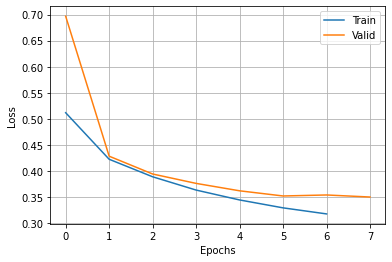

In [35]:
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

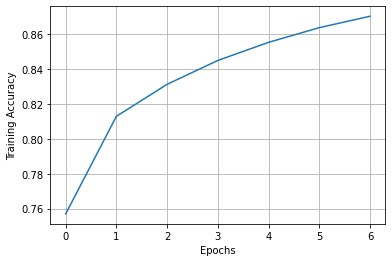

In [36]:
plt.plot(train_accs)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.grid()

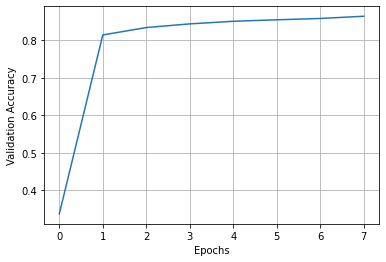

In [37]:
plt.plot(valid_accs)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.grid()

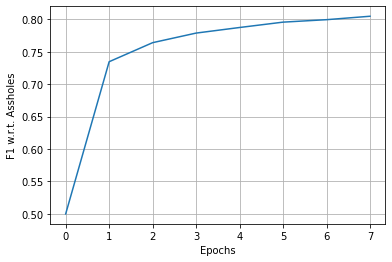

In [38]:
plt.plot(valid_f1s_ass)
plt.xlabel("Epochs")
plt.ylabel("F1 w.r.t. Assholes")
plt.grid()

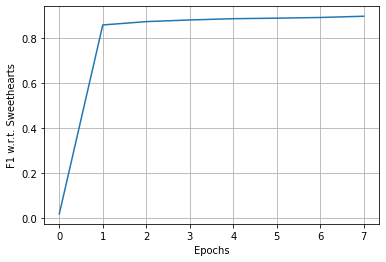

In [39]:
plt.plot(valid_f1s_sweet)
plt.xlabel("Epochs")
plt.ylabel("F1 w.r.t. Sweethearts")
plt.grid()

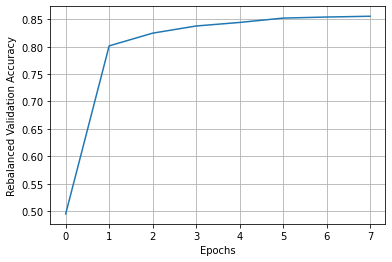

In [40]:
plt.plot(valid_reb_accs)
plt.xlabel("Epochs")
plt.ylabel("Rebalanced Validation Accuracy")
plt.grid()

Report performance on test set

In [41]:
def test_model(model, dataloader, device, include_weights=True, print_conf_matr_on=True):
    '''
    Function that performs evaluation of the given model for one full pass of the samples in the give dataloader
    '''

    model = model.eval()

    losses = []
    # Instantiate the total confusion metric for the whole validation epoch
    total_conf_matr = np.array([[0, 0], [0, 0]])

    with torch.no_grad():
        for batch in dataloader:

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            y = batch['targets'].float().to(device)
            if include_weights:
                w = batch['weights'].to(device)

            # Send the current batch through the model to get output probabilities
            y_out = model(input_ids=input_ids, attention_mask=attention_mask)
            del input_ids, attention_mask

            # Turn the probabilities into binary predictions
            y_preds = y_out.detach()
            y_preds = torch.where(y_preds > 0.5, 1, 0)

            # Get the confusion matrix for the current batch and add it to the total confusion matrix
            small_conf_matr = confusion_matrix(y.cpu(), y_preds.cpu())
            total_conf_matr += small_conf_matr

            # Get the mean loss for the batch
            if include_weights:
                loss_fn = nn.BCELoss(weight=w, reduction="mean").to(device)
            else:
                loss_fn = nn.BCELoss(reduction="mean").to(device)
            loss = loss_fn(y_out, y.float())
            losses.append(loss.item())

            torch.cuda.empty_cache()
            del y

    # Get various metrics from the total confusion matrix
    asshole_recall, sweetheart_recall, asshole_precision, sweetheart_precision, accuracy, f1_ass, f1_sweet = get_metrics_from_conf_matrix(total_conf_matr, print_on=print_conf_matr_on)

    # Get the average loss for the current evaluation epoch by averaging all batch-averaged losses.
    epoch_loss = np.mean(losses)

    # Return the appropriate evaluation metrics
    return epoch_loss, accuracy, f1_ass, f1_sweet, asshole_precision, sweetheart_precision, asshole_recall, sweetheart_recall

In [42]:
print("Performance on test set:")
test_loss, test_accuracy, test_f1_ass, test_f1_sweet, test_precision_ass, test_precision_sweet, test_recall_ass, test_recall_sweet = test_model(model, valid_loader, device, include_weights=False, print_conf_matr_on=True)
print()

Performance on test set:
Here is the confusion matrix:
[[8964 1211]
 [ 864 4273]]

Here are the metrics derived from the confusion matrix:
recall wrt assholes = 0.8318084485108039
recall wrt sweethearts = 0.880982800982801
precision wrt assholes = 0.7791757840991976
precision wrt sweethearts) = 0.9120879120879121

accuracy = 0.8644853709508882
f1 wrt assholes = 0.8046323321721118
f1 wrt sweethearts = 0.8962655601659751



In [43]:
batch = next(iter(train_loader))

input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)

X = (input_ids, attention_mask)
with torch.no_grad():
    torch.jit.save(torch.jit.trace(model, (X), check_trace=False), '/content/drive/MyDrive/MastersProject/SavedModels/BertPooledPlusFFNNFinalToClassifyComments.pth')

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:2155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input_tensor.shape[chunk_dim] == tensor_shape for input_tensor in input_tensors


In [44]:
def create_texts_predictions_df_for_grasp(model, dataloader, device):
    texts = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            y = batch['targets'].float().to(device)
            textss = batch['sample_text']

            # Send the current batch through the model to get output probabilities
            y_out = model(input_ids=input_ids, attention_mask=attention_mask)
            del input_ids, attention_mask

            # Turn the probabilities into binary predictions
            y_preds = y_out.detach()
            y_preds = torch.where(y_preds > 0.5, 1, 0)

            labels.extend([label.item() for label in y_preds])
            texts.extend(textss)
    
    data_dict = {"text": texts, "predicted_label": labels}
    df = pd.DataFrame(data_dict)
    
    return df

In [45]:
df = create_texts_predictions_df_for_grasp(model, valid_loader, device)
df.to_csv('drive/MyDrive/MastersProject/SavedPredictedLabels-Texts/Comments-PredictedLabels.csv', index=False)